In [1]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

In [2]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=57)

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[-0.79885014 -0.21122146]
 [-0.40416824 -0.93006724]
 [ 0.35952679  0.92226024]
 [ 0.81032948  0.16657051]
 [-0.65233723 -0.77880979]]

First 5 y labels:
[1 0 0 1 0]


In [4]:
import pandas as pd

circles = pd.DataFrame({"x1" : X[:,0], "x2" : X[:,1], "label": y})

circles.head(10)

,x1,x2,label
0,-0.798850,-0.211221,1
1,-0.404168,-0.930067,0
2,0.359527,0.922260,0
3,0.810329,0.166571,1
4,-0.652337,-0.778810,0
5,-0.732504,-0.388679,1
6,0.884260,-0.508534,0
7,0.550650,0.843505,0
8,0.636806,0.733344,0
9,0.041497,-0.975589,0


In [5]:
circles["label"].value_counts()

label
1    500
0    500
Name: count, dtype: int64

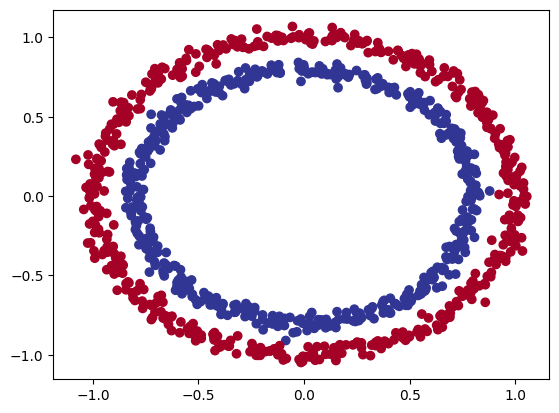

In [6]:
import matplotlib.pyplot as plt

plt.scatter(
    x = X[:,0],
    y = X[:,1],
    c = y,
    cmap=plt.cm.RdYlBu
)

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-0.7989, -0.2112],
         [-0.4042, -0.9301],
         [ 0.3595,  0.9223],
         [ 0.8103,  0.1666],
         [-0.6523, -0.7788]]),
 tensor([1., 0., 0., 1., 0.]))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=57)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, X):
        return self.layer2(self.layer1(X))

In [12]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [14]:
untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.1603],
        [-0.0644],
        [-0.1021],
        [-0.0730],
        [-0.0036],
        [ 0.2564],
        [-0.0891],
        [ 0.1967],
        [ 0.1859],
        [-0.0598]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 0.])


In [15]:
loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)


In [16]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [17]:
train_loss_values = []
test_loss_values = []
epoch_counts = []

epochs = 500

X_test = X_test.to(device)
X_train = X_train.to(device)
y_test = y_test.to(device)
y_train = y_train.to(device)

for epoch in range(epochs):

    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_function(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred =  torch.round(torch.sigmoid(test_logits))
        test_loss = loss_function(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    
    if epoch % 10 == 0:
        epoch_counts.append(epoch)
        train_loss_values.append(loss.detach().cpu().numpy())
        test_loss_values.append(test_loss.detach().cpu().numpy())
        print(f"Epoch: {epoch} | BCE Train Loss: {loss} | BCE Test Loss: {test_loss} ")


Epoch: 0 | BCE Train Loss: 0.6948886513710022 | BCE Test Loss: 0.7024259567260742 
Epoch: 10 | BCE Train Loss: 0.6945962905883789 | BCE Test Loss: 0.7025858163833618 
Epoch: 20 | BCE Train Loss: 0.6943346261978149 | BCE Test Loss: 0.7027505040168762 
Epoch: 30 | BCE Train Loss: 0.6941003203392029 | BCE Test Loss: 0.7029183506965637 
Epoch: 40 | BCE Train Loss: 0.693890392780304 | BCE Test Loss: 0.7030876278877258 
Epoch: 50 | BCE Train Loss: 0.6937022805213928 | BCE Test Loss: 0.7032572031021118 
Epoch: 60 | BCE Train Loss: 0.6935335993766785 | BCE Test Loss: 0.7034258246421814 
Epoch: 70 | BCE Train Loss: 0.6933823823928833 | BCE Test Loss: 0.7035925984382629 
Epoch: 80 | BCE Train Loss: 0.6932467222213745 | BCE Test Loss: 0.7037568688392639 
Epoch: 90 | BCE Train Loss: 0.6931250095367432 | BCE Test Loss: 0.7039178013801575 
Epoch: 100 | BCE Train Loss: 0.6930157542228699 | BCE Test Loss: 0.7040751576423645 
Epoch: 110 | BCE Train Loss: 0.69291752576828 | BCE Test Loss: 0.704228341579

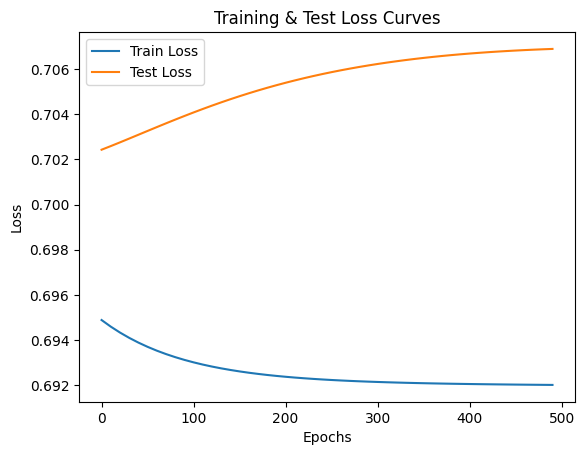

In [18]:
plt.plot(epoch_counts, train_loss_values, label = "Train Loss")
plt.plot(epoch_counts, test_loss_values, label = "Test Loss")
plt.title("Training & Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [19]:
import requests
from pathlib import Path


if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")

else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


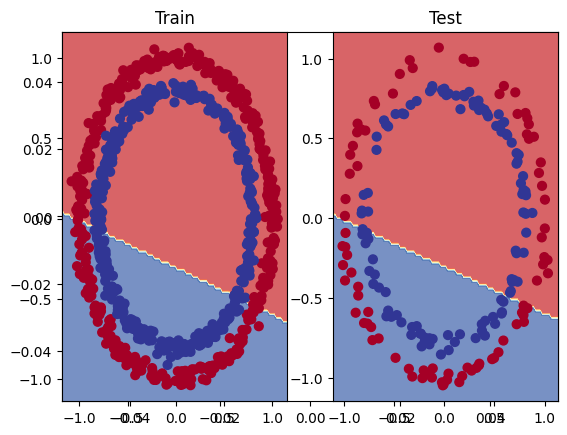

In [24]:
plt.plot(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [36]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        z = self.layer1(X)
        z = self.layer2(z)
        z = self.layer3(z)
        return z

In [37]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr = 0.05)

In [39]:
train_loss_values = []
test_loss_values = []
epoch_counts = []

epochs = 1000

torch.manual_seed(57)


X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        epoch_counts.append(epoch)
        train_loss_values.append(loss.detach().cpu().numpy())
        test_loss_values.append(test_loss.detach().cpu().numpy())
        print(f"Epoch: {epoch} | BCE Train Loss: {loss} | BCE Test Loss: {test_loss} ")

Epoch: 0 | BCE Train Loss: 0.6966202259063721 | BCE Test Loss: 0.6852256655693054 
Epoch: 100 | BCE Train Loss: 0.6926517486572266 | BCE Test Loss: 0.6971089839935303 
Epoch: 200 | BCE Train Loss: 0.6921100616455078 | BCE Test Loss: 0.7004126310348511 
Epoch: 300 | BCE Train Loss: 0.6919464468955994 | BCE Test Loss: 0.702241063117981 
Epoch: 400 | BCE Train Loss: 0.6918917894363403 | BCE Test Loss: 0.7032765746116638 
Epoch: 500 | BCE Train Loss: 0.6918710470199585 | BCE Test Loss: 0.7038632035255432 
Epoch: 600 | BCE Train Loss: 0.691862165927887 | BCE Test Loss: 0.7042005658149719 
Epoch: 700 | BCE Train Loss: 0.6918579936027527 | BCE Test Loss: 0.7043999433517456 
Epoch: 800 | BCE Train Loss: 0.6918558478355408 | BCE Test Loss: 0.7045214772224426 
Epoch: 900 | BCE Train Loss: 0.69185471534729 | BCE Test Loss: 0.704598069190979 


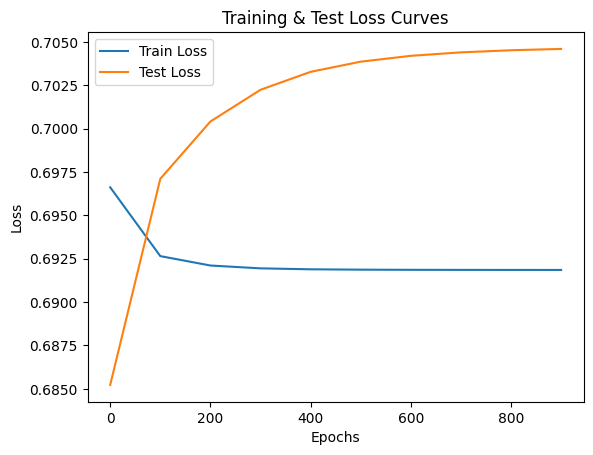

In [40]:
plt.plot(epoch_counts, train_loss_values, label = "Train Loss")
plt.plot(epoch_counts, test_loss_values, label = "Test Loss")
plt.title("Training & Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

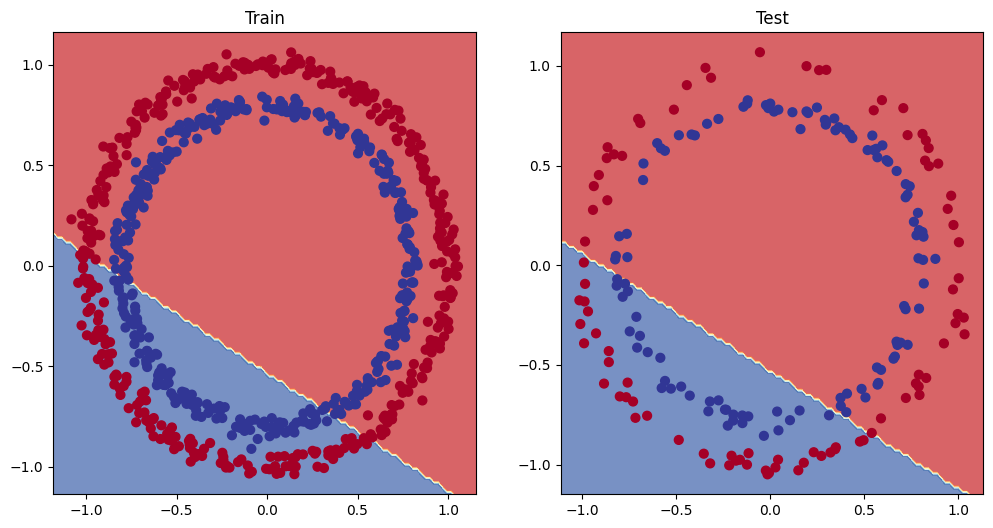

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [42]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, X:torch.Tensor) -> torch.Tensor:
        z = self.relu(self.layer1(X))
        z = self.relu(self.layer2(z))
        return self.layer3(z)

In [45]:
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [54]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [55]:
torch.manual_seed(57)
epochs = 1000

for epoch in range(epochs):

    model_2.train()

    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = criterion(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = criterion(test_logits, y_test)
        test_Acc = accuracy_fn(y_true=y_test, y_pred=test_pred)


    if epoch % 100 == 0:
         print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.67555, Accuracy: 55.88% | Test Loss: 0.68856, Test Accuracy: 41.50%
Epoch: 100 | Loss: 0.66612, Accuracy: 58.50% | Test Loss: 0.68229, Test Accuracy: 41.50%
Epoch: 200 | Loss: 0.65156, Accuracy: 59.88% | Test Loss: 0.66887, Test Accuracy: 41.50%
Epoch: 300 | Loss: 0.62546, Accuracy: 74.62% | Test Loss: 0.63914, Test Accuracy: 41.50%
Epoch: 400 | Loss: 0.57840, Accuracy: 89.38% | Test Loss: 0.58619, Test Accuracy: 41.50%
Epoch: 500 | Loss: 0.49941, Accuracy: 95.25% | Test Loss: 0.49990, Test Accuracy: 41.50%
Epoch: 600 | Loss: 0.38882, Accuracy: 98.50% | Test Loss: 0.38856, Test Accuracy: 41.50%
Epoch: 700 | Loss: 0.27114, Accuracy: 99.38% | Test Loss: 0.26982, Test Accuracy: 41.50%
Epoch: 800 | Loss: 0.17456, Accuracy: 99.75% | Test Loss: 0.17091, Test Accuracy: 41.50%
Epoch: 900 | Loss: 0.11319, Accuracy: 99.75% | Test Loss: 0.10973, Test Accuracy: 41.50%


In [58]:
model_2.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0'),
 tensor([1., 0., 0., 1., 0., 1., 0., 0., 0., 0.]))

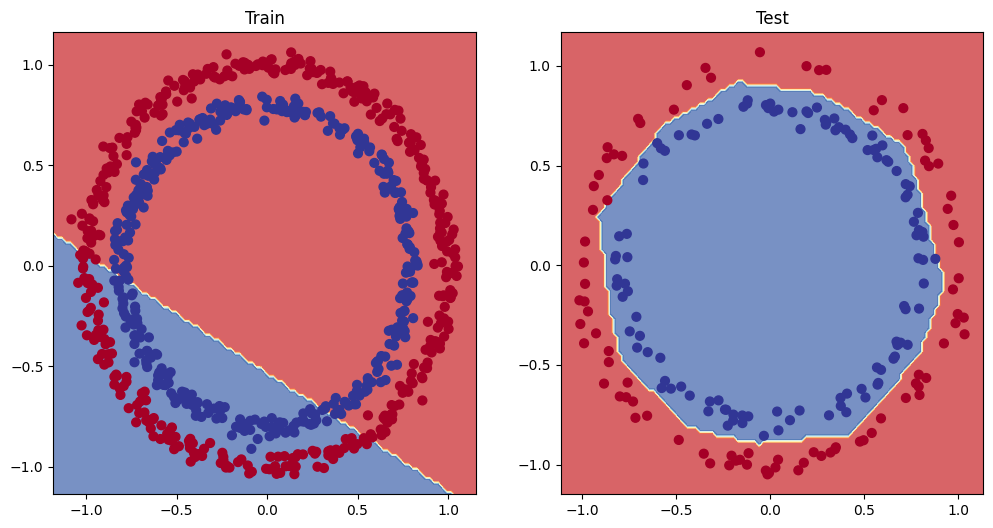

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test) # model_2 = has non-linearity